In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import re

In [2]:

def read_file(file):
    # Check if file exists
    if not os.path.exists(file):
        print(f"File not found: {file}")
        return None
    
    # Check if file is empty
    if os.stat(file).st_size == 0:
        print(f"File is empty: {file}")
        return None

    # Try reading the file with pandas
    try:
        df = pd.read_csv(file, encoding='utf-8-sig')
        return df
    except pd.errors.EmptyDataError:
        print(f"No data to parse in file: {file}")
        return None
    
def load_data_from_csv(folder_path, sequence_length=20):
    csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    X = []
    y = []

    for file in csv_files:
        # Extract PID values from the filename
        file_name = os.path.basename(file)
        Kp, Ki, Kd = extract_pid_values_from_filename(file_name)
        
        # Load data from CSV
        df = read_file(file)
        
        # Assuming the CSV contains columns: 'Time', 'Pitch', 'PWM'
        df = df[['Pitch', 'PWM']]

        # Normalize the data
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df)

        # Create sequences for LSTM input
        for i in range(sequence_length, len(scaled_data)):
            X.append(scaled_data[i-sequence_length:i])
            y.append([Kp, Ki, Kd])

    X, y = np.array(X), np.array(y)
    return X, y

def extract_pid_values_from_filename(filename):
    # Assuming filename format is '#.gyro_pwm_data_KpXX_KiXX_KdXX.csv'
    print(f"Processing filename: {filename}")
    
    # Regex to extract Kp, Ki, Kd values
    kp_match = re.search(r'Kp([0-9.]+)', filename)
    ki_match = re.search(r'Ki([0-9.]+)', filename)
    kd_match = re.search(r'Kd([0-9.]+)', filename)
    
    # Check if matches are found
    if kp_match and ki_match and kd_match:
        Kp = float(kp_match.group(1))
        Ki = float(ki_match.group(1))
        Kd = float(kd_match.group(1).rstrip('.'))
        return Kp, Ki, Kd
    else:
        raise ValueError("Could not extract PID values from filename")

# Step 2: Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(3))  # Output: Kp, Ki, Kd
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Step 3: Train and evaluate the model
def train_model(X_train, y_train, X_test, y_test, model, epochs=50, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    
    # Plot training history
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

# Step 4: Evaluate accuracy
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"Mean Squared Error: {mse}")

    # Plot true vs predicted values for a subset
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:50, 0], label="True Kp", color='blue')
    plt.plot(predictions[:50, 0], label="Predicted Kp", linestyle='--', color='red')
    plt.plot(y_test[:50, 1], label="True Ki", color='green')
    plt.plot(predictions[:50, 1], label="Predicted Ki", linestyle='--', color='orange')
    plt.plot(y_test[:50, 2], label="True Kd", color='purple')
    plt.plot(predictions[:50, 2], label="Predicted Kd", linestyle='--', color='pink')
    plt.legend()
    plt.title("True vs Predicted PID Values")

    # Annotate the end of each predicted PID value on the graph
    for i, label in enumerate(["Kp", "Ki", "Kd"]):
        plt.annotate(f"Pred: {predictions[49, i]:.2f}",
                     xy=(49, predictions[49, i]),
                     xytext=(49, predictions[49, i] + 2),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=10,
                     color='red' if label == "Kp" else ('orange' if label == "Ki" else 'pink'))

    plt.show()
# def evaluate_model(model, X_test, y_test):
#     predictions = model.predict(X_test)
#     mse = mean_squared_error(y_test, predictions)
#     print(f"Mean Squared Error: {mse}")

#     # Plot true vs predicted values for a subset
#     plt.figure(figsize=(10, 6))
#     plt.plot(y_test[:50, 0], label="True Kp", color='blue')
#     plt.plot(predictions[:50, 0], label="Predicted Kp", linestyle='--', color='red')
#     plt.plot(y_test[:50, 1], label="True Ki", color='green')
#     plt.plot(predictions[:50, 1], label="Predicted Ki", linestyle='--', color='orange')
#     plt.plot(y_test[:50, 2], label="True Kd", color='purple')
#     plt.plot(predictions[:50, 2], label="Predicted Kd", linestyle='--', color='pink')
#     plt.legend()
#     plt.title("True vs Predicted PID Values")
    
#     plt.show()


In [3]:
train_folder_path = 'train'
test_folder_path = 'test'

Iteration 1...
Processing filename: 10.gyro_pwm_data_Kp34.00284196998793_Ki0.09166628799328863_Kd1.727660976277776.csv
Processing filename: 11.gyro_pwm_data_Kp32.39986804364504_Ki0.03568322389595223_Kd2.19459528635083.csv
Processing filename: 12.gyro_pwm_data_Kp39.076113312299285_Ki0.02460486232252404_Kd2.291403578112201.csv
Processing filename: 13.gyro_pwm_data_Kp39.915973554572815_Ki0.010863266382422658_Kd0.8734315988434765.csv
Processing filename: 14.gyro_pwm_data_Kp35.30930129518271_Ki0.0874627852307752_Kd1.753277263853207.csv
Processing filename: 15.gyro_pwm_data_Kp30.155071046321257_Ki0.10082738754403409_Kd1.4121085897344927.csv
Processing filename: 3.gyro_pwm_data_Kp33.21606577976306_Ki0.031226615845182153_Kd1.80458483086225.csv
Processing filename: 3.gyro_pwm_data_Kp39.89076297639663_Ki0.11747314670257317_Kd1.671084077146697.csv
Processing filename: 4.gyro_pwm_data_Kp31.815558858844472_Ki0.08599390006913922_Kd1.0731389312890423.csv
Processing filename: 4.gyro_pwm_data_Kp32.1898

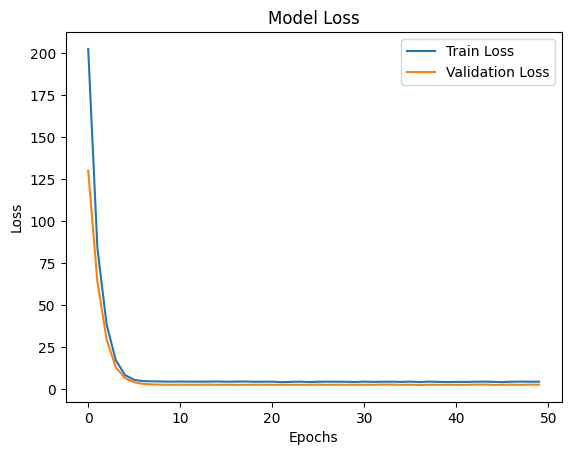

43/43 [==============================] - 1s 6ms/step
Mean Squared Error: 2.664901979107856


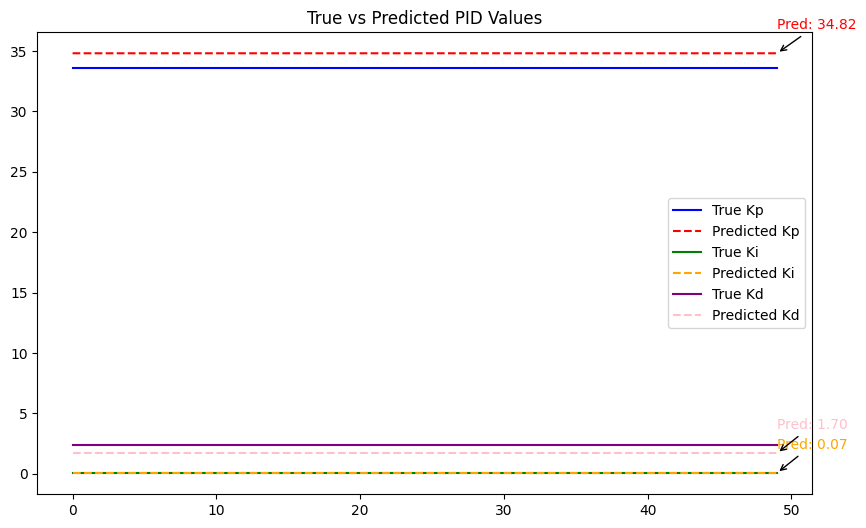

Iteration 2...
Processing filename: 10.gyro_pwm_data_Kp34.00284196998793_Ki0.09166628799328863_Kd1.727660976277776.csv
Processing filename: 11.gyro_pwm_data_Kp32.39986804364504_Ki0.03568322389595223_Kd2.19459528635083.csv
Processing filename: 12.gyro_pwm_data_Kp39.076113312299285_Ki0.02460486232252404_Kd2.291403578112201.csv
Processing filename: 13.gyro_pwm_data_Kp39.915973554572815_Ki0.010863266382422658_Kd0.8734315988434765.csv
Processing filename: 14.gyro_pwm_data_Kp35.30930129518271_Ki0.0874627852307752_Kd1.753277263853207.csv
Processing filename: 15.gyro_pwm_data_Kp30.155071046321257_Ki0.10082738754403409_Kd1.4121085897344927.csv
Processing filename: 3.gyro_pwm_data_Kp33.21606577976306_Ki0.031226615845182153_Kd1.80458483086225.csv
Processing filename: 3.gyro_pwm_data_Kp39.89076297639663_Ki0.11747314670257317_Kd1.671084077146697.csv
Processing filename: 4.gyro_pwm_data_Kp31.815558858844472_Ki0.08599390006913922_Kd1.0731389312890423.csv
Processing filename: 4.gyro_pwm_data_Kp32.1898

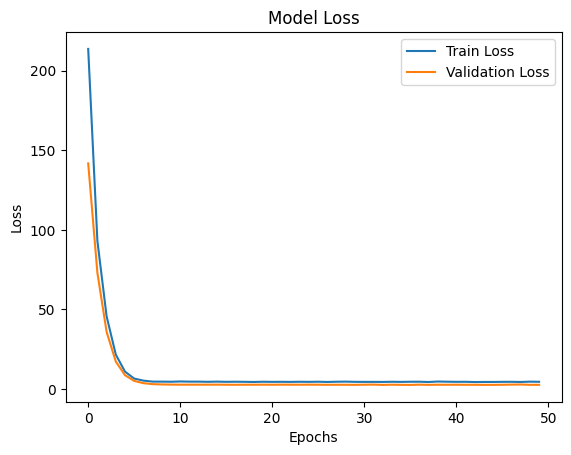

43/43 [==============================] - 1s 6ms/step
Mean Squared Error: 2.5887290075477805


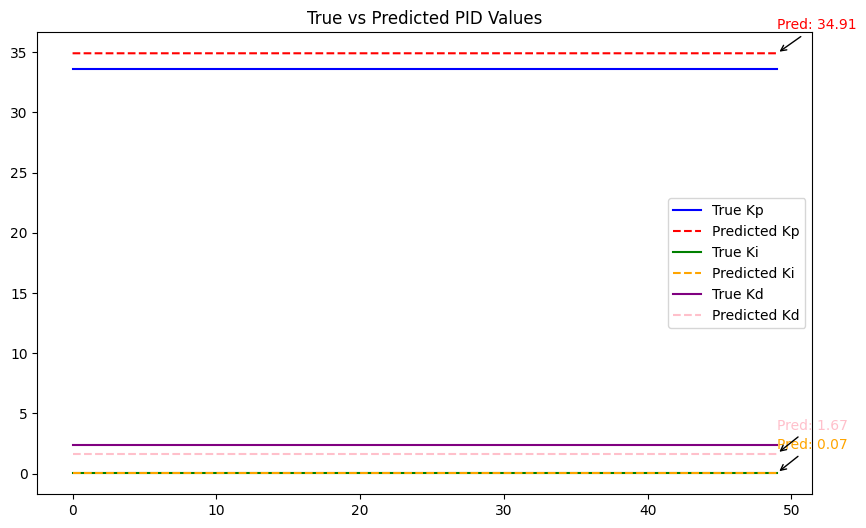

Iteration 3...
Processing filename: 10.gyro_pwm_data_Kp34.00284196998793_Ki0.09166628799328863_Kd1.727660976277776.csv
Processing filename: 11.gyro_pwm_data_Kp32.39986804364504_Ki0.03568322389595223_Kd2.19459528635083.csv
Processing filename: 12.gyro_pwm_data_Kp39.076113312299285_Ki0.02460486232252404_Kd2.291403578112201.csv
Processing filename: 13.gyro_pwm_data_Kp39.915973554572815_Ki0.010863266382422658_Kd0.8734315988434765.csv
Processing filename: 14.gyro_pwm_data_Kp35.30930129518271_Ki0.0874627852307752_Kd1.753277263853207.csv
Processing filename: 15.gyro_pwm_data_Kp30.155071046321257_Ki0.10082738754403409_Kd1.4121085897344927.csv
Processing filename: 3.gyro_pwm_data_Kp33.21606577976306_Ki0.031226615845182153_Kd1.80458483086225.csv
Processing filename: 3.gyro_pwm_data_Kp39.89076297639663_Ki0.11747314670257317_Kd1.671084077146697.csv
Processing filename: 4.gyro_pwm_data_Kp31.815558858844472_Ki0.08599390006913922_Kd1.0731389312890423.csv
Processing filename: 4.gyro_pwm_data_Kp32.1898

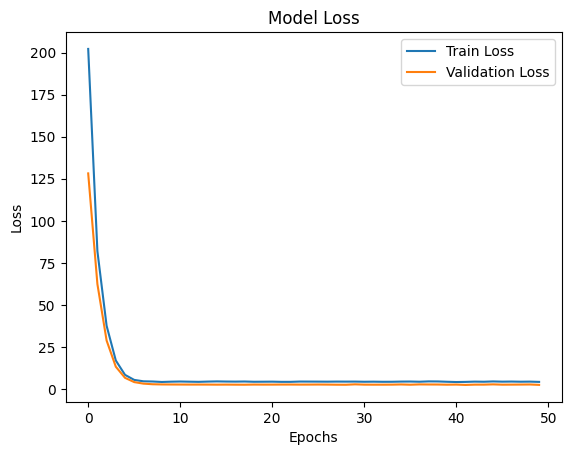

43/43 [==============================] - 10s 40ms/step
Mean Squared Error: 2.4961103257502626


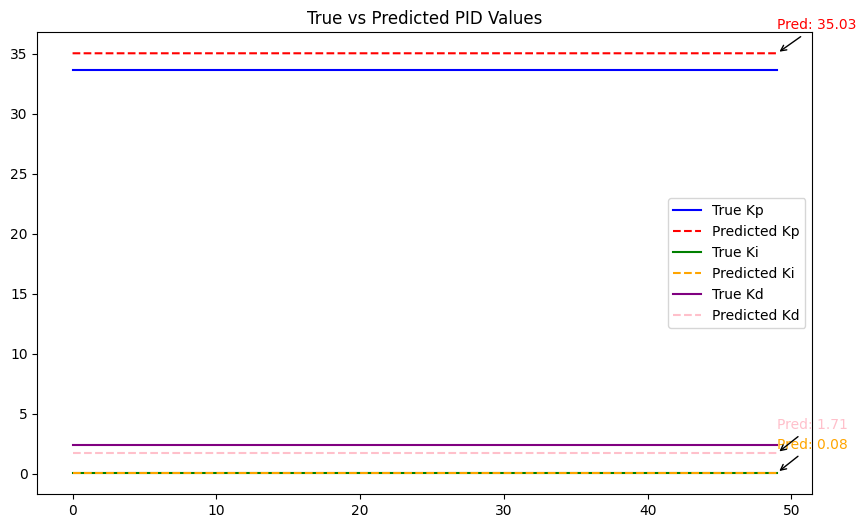

Mean Squared Errors for 30 iterations: [None, None, None]


In [4]:
# Prepare to store results for multiple iterations
all_mse_results = []

# for i in range(30):
for i in range(3):
    print(f"Iteration {i+1}...")
    
    # Load training and testing data
    X_train, y_train = load_data_from_csv(train_folder_path, sequence_length=20)
    X_test, y_test = load_data_from_csv(test_folder_path, sequence_length=20)

    # Build LSTM model
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

    # Train the model
    trained_model = train_model(X_train, y_train, X_test, y_test, model, epochs=50, batch_size=32)

    # Evaluate the model accuracy
    mse = evaluate_model(trained_model, X_test, y_test)
    all_mse_results.append(mse)

# Print all results
print(f"Mean Squared Errors for 30 iterations: {all_mse_results}")